In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
import statsmodels.api as sm
import statsmodels as sms
import phik
#supress warnings
import warnings
warnings.filterwarnings('ignore')

# Read the dataset:

In [5]:
# df_original = pd.read_csv('CZ3A_hp_slab_noFMU.csv')
df_original = pd.read_csv('train_data.csv')

# Dataset description:

In [6]:
df_original.shape

(960, 30)

In [7]:
df_original.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Time_secs           960 non-null    int64  
 1   h_daytype           960 non-null    int64  
 2   occup               960 non-null    float64
 3   T_od                960 non-null    float64
 4   T_id                960 non-null    float64
 5   T_sp_c              960 non-null    int64  
 6   T_sp_h              960 non-null    float64
 7   T_comp_sp           960 non-null    int64  
 8   T_tank_wh_sp        960 non-null    int64  
 9   T_wh_tank           960 non-null    float64
 10  m_wh_tank_use       960 non-null    float64
 11  m_evap_source       960 non-null    float64
 12  T_wh_tank_inlet     960 non-null    float64
 13  T_wh_tank_outlet    960 non-null    float64
 14  T_evap_inlet        960 non-null    float64
 15  T_evap_outlet       960 non-null    float64
 16  S_dishwa

All variables are of datatype int or float. 
- The date variable is of type int64 - Let's convert this column into datetime. 
- h_daytype, occup - convert into categorical
- T_sp_c; T_comp_sp; T_tank_wh_sp; S_dishwasher; S_clotheswasher; S_sink; S_shower; S_bath; S_refrigerator; P_light_total; P_other_elec_total - same value - why? - explain for each

Removing same value columns; converting datetime, we have

In [8]:
# Let's first make copy of the dataset so we don't end up modifying the original one
df = df_original

In [6]:
df['Date/Time'] = df['Date/Time'].str.strip()
def custom_to_datetime(date):
    # If the time is 24, set it to 0 and increment day by 1
    if date[7:9] == '24':
        return pd.to_datetime(date[:-10], format = '%m/%d') + pd.Timedelta(days=1)
    else:
        return pd.to_datetime(date, format = '%m/%d %H:%M:%S')

df['Date/Time'] = df['Date/Time'].apply(custom_to_datetime) 
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 117 columns):
 #    Column                                                                                              Non-Null Count  Dtype         
---   ------                                                                                              --------------  -----         
 0    Date/Time                                                                                           8760 non-null   datetime64[ns]
 1    Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)                                        8760 non-null   float64       
 2    Environment:Site Day Type Index [](Hourly)                                                          8760 non-null   int64         
 3    PEOPLE_UNIT1:People Occupant Count [](Hourly)                                                       8760 non-null   float64       
 4    LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly)  

In [7]:
# Remove all columns with value = 0
zero_cols = [ col for col, is_zero in ((df == 0).sum() == df.shape[0]).items() if is_zero ]
print(zero_cols)
df.drop(zero_cols, axis=1, inplace=True)

['TELEVISION1:Electric Equipment Electricity Rate [W](Hourly)', 'HEAT PUMP WATER HEATER EVAPORATOR_UNIT1:Cooling Coil Crankcase Heater Electricity Rate [W](Hourly)', 'LIVING_UNIT1:Zone Ventilation Fan Electricity Energy [J](Hourly)', 'SHADING_2012IECC:Schedule Value [](Hourly)', 'ALWAYS_OFF:Schedule Value [](Hourly)', 'FAN_CYCLE:Schedule Value [](Hourly)', 'BATHLATSCHEDULE:Schedule Value [](Hourly)', 'MAINS PRESSURE_UNIT1:Pump Electricity Rate [W](Hourly)', 'WATER HEATER_TANK_UNIT1:Water Heater Source Side Mass Flow Rate [kg/s](Hourly)', 'WATER HEATER_TANK_UNIT1:Water Heater Electricity Rate [W](Hourly)', 'WATER HEATER_TANK_UNIT1:Water Heater Off Cycle Parasitic Electricity Rate [W](Hourly)', 'WATER HEATER_TANK_UNIT1:Water Heater On Cycle Parasitic Electricity Rate [W](Hourly)', 'WATER HEATER_UNIT1:Water Heater Off Cycle Ancillary Electricity Rate [W](Hourly)', 'WATER HEATER_UNIT1:Water Heater On Cycle Ancillary Electricity Rate [W](Hourly)']


In [8]:
# Remove all columns with same value in all rows
nunique = df.nunique()
cols_to_drop = nunique[nunique == 1].index
print(cols_to_drop)
df.drop(cols_to_drop, axis=1, inplace=True)

Index(['OASUPPLYFAN_UNIT1:Fan Electricity Rate [W](Hourly)',
       'OAEXHAUSTFAN_UNIT1:Fan Electricity Rate [W](Hourly)',
       'LIVING_UNIT1:Zone Thermostat Heating Setpoint Temperature [C](Hourly)',
       'LIVING_UNIT1:Zone Thermostat Cooling Setpoint Temperature [C](Hourly)',
       'ACTIVITY_SCH:Schedule Value [](Hourly)',
       'INF_SCH:Schedule Value [](Hourly)',
       'ZONE_CONTROL_TYPE:Schedule Value [](Hourly)',
       'DHW_SETPT:Schedule Value [](Hourly)',
       'DHW_SETPT_HPWH:Schedule Value [](Hourly)',
       'SUPPLY-AIR-TEMP-SCH:Schedule Value [](Hourly)',
       'ALWAYS_AVAIL:Schedule Value [](Hourly)',
       'HEATING_SCH_HREF:Schedule Value [](Hourly)',
       'COOLING_SCH_HREF:Schedule Value [](Hourly)',
       'HEATING_SCH:Schedule Value [](Hourly)',
       'COOLING_SCH:Schedule Value [](Hourly)',
       'DWWATERTEMPSCHEDULE:Schedule Value [](Hourly)',
       'CWWATERTEMPSCHEDULE:Schedule Value [](Hourly)',
       'SINKSENSSCHEDULE:Schedule Value [](Hourly)',
 

In [9]:
# Convert columns with less than 6 unique values to categorical
nunique = df.nunique()
cols_to_cat = nunique[nunique <= 7].index
print(cols_to_cat)
for col in cols_to_cat:
    df[col] = df[col].astype('category')

Index(['Environment:Site Day Type Index [](Hourly)',
       'PEOPLE_UNIT1:People Occupant Count [](Hourly)',
       'OCCUPANCY:Schedule Value [](Hourly)',
       'EXTERIORLIGHTING:Schedule Value [](Hourly)',
       'SHADING_2009IECC:Schedule Value [](Hourly)',
       'EXTERIOR-LIGHTS_UNIT1:Exterior Lights Electricity Rate [W](Hourly)'],
      dtype='object')


In [10]:
df.info(verbose= True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 72 columns):
 #   Column                                                                                           Non-Null Count  Dtype         
---  ------                                                                                           --------------  -----         
 0   Date/Time                                                                                        8760 non-null   datetime64[ns]
 1   Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)                                     8760 non-null   float64       
 2   Environment:Site Day Type Index [](Hourly)                                                       8760 non-null   category      
 3   PEOPLE_UNIT1:People Occupant Count [](Hourly)                                                    8760 non-null   category      
 4   LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly)                            

In [11]:
df.head(5)

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Day Type Index [](Hourly),PEOPLE_UNIT1:People Occupant Count [](Hourly),LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly),LIVING PLUG-IN LIGHTING1:Lights Electricity Rate [W](Hourly),DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly),REFRIGERATOR1:Electric Equipment Electricity Rate [W](Hourly),CLOTHESWASHER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_DRYER1:Electric Equipment Electricity Rate [W](Hourly),...,WATER HEATER USE INLET NODE_UNIT1:System Node Mass Flow Rate [kg/s](Hourly),WATER HEATER USE OUTLET NODE_UNIT1:System Node Temperature [C](Hourly),WATER HEATER USE OUTLET NODE_UNIT1:System Node Mass Flow Rate [kg/s](Hourly),Electricity:HVAC [J](Hourly),Cooling:Electricity [J](Hourly),Heating:Electricity [J](Hourly),Fans:Electricity [J](Hourly),WaterSystems:Electricity [J](Hourly),Electricity:Facility [J](Hourly),ElectricityPurchased:Facility [J](Hourly)
0,1900-01-01 01:00:00,4.758333,7,3.0,15.973112,7.263726,8.155457,72.846060,2.774968,25.983483,...,0.000679,49.697860,0.000679,7773540.169,0.0,6807120.579,966419.5902,0.0,1.043835e+07,1.043835e+07
1,1900-01-01 02:00:00,4.975000,7,3.0,15.973112,7.263726,3.623467,71.270415,2.219380,15.590090,...,0.000373,49.193685,0.000373,7594289.657,0.0,6637855.460,956434.1970,0.0,1.004024e+07,1.004024e+07
2,1900-01-01 03:00:00,5.391667,7,3.0,15.973112,7.263726,2.714944,69.713093,1.108205,10.393393,...,0.000235,48.830153,0.000235,5083821.401,0.0,4308046.893,775774.5077,0.0,7.455888e+06,7.455888e+06
3,1900-01-01 04:00:00,5.950000,7,3.0,15.973112,7.263726,1.811734,67.642770,1.108205,5.196697,...,0.000261,48.504251,0.000261,4597998.941,0.0,3893809.618,704189.3225,0.0,6.915206e+06,6.915206e+06
4,1900-01-01 05:00:00,6.258333,7,3.0,47.919336,21.791179,1.811734,66.598447,2.219380,10.393393,...,0.000528,48.096483,0.000528,4251860.191,0.0,3597687.612,654172.5788,0.0,6.712634e+06,6.712634e+06


In [12]:
# Let's check for null values
df.isna().sum()

Date/Time                                                         0
Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)      0
Environment:Site Day Type Index [](Hourly)                        0
PEOPLE_UNIT1:People Occupant Count [](Hourly)                     0
LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly)    0
                                                                 ..
Heating:Electricity [J](Hourly)                                   0
Fans:Electricity [J](Hourly)                                      0
WaterSystems:Electricity [J](Hourly)                              0
Electricity:Facility [J](Hourly)                                  0
ElectricityPurchased:Facility [J](Hourly)                         0
Length: 72, dtype: int64

In [13]:
df.isna().sum().sum()

0

No missing values in the dataset. Why are there no missing values?

In [14]:
# Let's check for columns which have > 60% zero values
colzero_to_drop = df.columns[df.eq(0).mean()>0.55]
print(colzero_to_drop)
df.drop(colzero_to_drop, axis=1, inplace=True)

Index(['HEAT PUMP WATER HEATER EVAPORATOR_UNIT1:Cooling Coil Water Heating Electricity Rate [W](Hourly)',
       'HEAT PUMP WATER HEATER FAN_UNIT1:Fan Electricity Rate [W](Hourly)',
       'HPWH ZONE INLET NODE_UNIT1:System Node Mass Flow Rate [kg/s](Hourly)',
       'ZONE EXHAUST NODE1_UNIT1:System Node Mass Flow Rate [kg/s](Hourly)',
       'Cooling:Electricity [J](Hourly)', 'Heating:Electricity [J](Hourly)',
       'WaterSystems:Electricity [J](Hourly)'],
      dtype='object')


Since more than 55% zeroes in rows would not give us any meaningful insight while predicting target variable. So, dropped them.

In [23]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 27 columns):
 #   Column                                                                       Non-Null Count  Dtype         
---  ------                                                                       --------------  -----         
 0   Date/Time                                                                    8760 non-null   datetime64[ns]
 1   Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)                 8760 non-null   float64       
 2   Environment:Site Day Type Index [](Hourly)                                   8760 non-null   category      
 3   PEOPLE_UNIT1:People Occupant Count [](Hourly)                                8760 non-null   category      
 4   LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly)               8760 non-null   float64       
 5   DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly)                  8760 non-null   floa

# Summary statistics of all variables

In [16]:
df.describe()

,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly),LIVING PLUG-IN LIGHTING1:Lights Electricity Rate [W](Hourly),DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly),REFRIGERATOR1:Electric Equipment Electricity Rate [W](Hourly),CLOTHESWASHER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_DRYER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_RANGE1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_MELS1:Electric Equipment Electricity Rate [W](Hourly),IECC_ADJ1:Electric Equipment Electricity Rate [W](Hourly),...,DHW SUPPLY OUTLET NODE_UNIT1:System Node Temperature [C](Hourly),MAINS MAKEUP NODE_UNIT1:System Node Temperature [C](Hourly),WATER HEATER USE INLET NODE_UNIT1:System Node Temperature [C](Hourly),WATER HEATER USE INLET NODE_UNIT1:System Node Mass Flow Rate [kg/s](Hourly),WATER HEATER USE OUTLET NODE_UNIT1:System Node Temperature [C](Hourly),WATER HEATER USE OUTLET NODE_UNIT1:System Node Mass Flow Rate [kg/s](Hourly),Electricity:HVAC [J](Hourly),Fans:Electricity [J](Hourly),Electricity:Facility [J](Hourly),ElectricityPurchased:Facility [J](Hourly)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8.760000e+03,8.760000e+03,8.760000e+03,8.760000e+03
mean,19.878493,81.423544,37.027120,21.083635,76.332478,10.767347,95.122066,68.960236,383.338898,230.252390,...,47.530019,23.113151,23.113289,0.002219,47.530019,0.002219,2.363848e+06,4.026119e+05,6.361227e+06,6.361227e+06
std,8.849494,69.929363,31.800175,14.229918,6.898357,6.698210,59.552442,59.037367,92.153775,55.352136,...,1.297350,5.444486,5.444355,0.001187,1.297350,0.001187,3.280316e+06,4.116223e+05,3.736698e+06,3.736698e+06
min,-16.016667,15.973112,7.263726,1.690951,66.598447,0.905837,4.247735,5.843012,293.392259,176.225969,...,45.122321,15.411246,15.411249,0.000185,45.122321,0.000185,7.714286e+04,7.714286e+04,2.389771e+06,2.389771e+06
25%,14.041667,29.949585,13.619487,9.651864,72.452149,3.896213,31.982278,17.545590,308.365476,185.219628,...,46.348363,17.662670,17.662110,0.001317,46.348363,0.001317,3.990623e+05,1.293156e+05,4.065250e+06,4.065250e+06
50%,20.562500,45.922697,20.883213,20.125650,75.447705,11.800165,112.135901,70.232015,342.704975,205.845637,...,47.495219,23.142012,23.142285,0.002364,47.495219,0.002364,1.435283e+06,2.717924e+05,5.395591e+06,5.395591e+06
75%,26.418750,111.811785,50.846085,28.770966,80.650995,14.524961,142.384235,84.860237,432.475278,259.766142,...,48.706524,28.525945,28.533047,0.003139,48.706524,0.003139,3.015752e+06,5.044230e+05,7.356057e+06,7.356057e+06
max,38.358333,232.336176,105.654202,58.931812,91.057575,25.545159,213.064557,248.154225,567.464237,340.847218,...,49.887905,30.810992,30.810988,0.004567,49.887905,0.004567,3.364254e+07,2.287625e+06,3.857570e+07,3.857570e+07


# Univariate Analysis:

For Numerical columns:

For numerical columns, histogram plot gives a better understanding of the distribution and dispersion of the data.

In [17]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly),LIVING PLUG-IN LIGHTING1:Lights Electricity Rate [W](Hourly),DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly),REFRIGERATOR1:Electric Equipment Electricity Rate [W](Hourly),CLOTHESWASHER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_DRYER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_RANGE1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_MELS1:Electric Equipment Electricity Rate [W](Hourly),IECC_ADJ1:Electric Equipment Electricity Rate [W](Hourly),...,DHW SUPPLY OUTLET NODE_UNIT1:System Node Temperature [C](Hourly),MAINS MAKEUP NODE_UNIT1:System Node Temperature [C](Hourly),WATER HEATER USE INLET NODE_UNIT1:System Node Temperature [C](Hourly),WATER HEATER USE INLET NODE_UNIT1:System Node Mass Flow Rate [kg/s](Hourly),WATER HEATER USE OUTLET NODE_UNIT1:System Node Temperature [C](Hourly),WATER HEATER USE OUTLET NODE_UNIT1:System Node Mass Flow Rate [kg/s](Hourly),Electricity:HVAC [J](Hourly),Fans:Electricity [J](Hourly),Electricity:Facility [J](Hourly),ElectricityPurchased:Facility [J](Hourly)
0,4.758333,15.973112,7.263726,8.155457,72.846060,2.774968,25.983483,11.702577,344.729004,207.061370,...,49.697860,16.135023,16.135023,0.000679,49.697860,0.000679,7773540.169,966419.5902,1.043835e+07,1.043835e+07
1,4.975000,15.973112,7.263726,3.623467,71.270415,2.219380,15.590090,11.702577,317.404608,190.648979,...,49.193685,16.135023,16.135023,0.000373,49.193685,0.000373,7594289.657,956434.1970,1.004024e+07,1.004024e+07
2,5.391667,15.973112,7.263726,2.714944,69.713093,1.108205,10.393393,5.843012,313.724554,188.438556,...,48.830153,16.135023,16.135023,0.000235,48.830153,0.000235,5083821.401,775774.5077,7.455888e+06,7.455888e+06
3,5.950000,15.973112,7.263726,1.811734,67.642770,1.108205,5.196697,5.843012,309.308490,185.786049,...,48.504251,16.135023,16.135023,0.000261,48.504251,0.000261,4597998.941,704189.3225,6.915206e+06,6.915206e+06
4,6.258333,47.919336,21.791179,1.811734,66.598447,2.219380,10.393393,11.702577,297.624320,178.767956,...,48.096483,16.135023,16.135023,0.000528,48.096483,0.000528,4251860.191,654172.5788,6.712634e+06,6.712634e+06


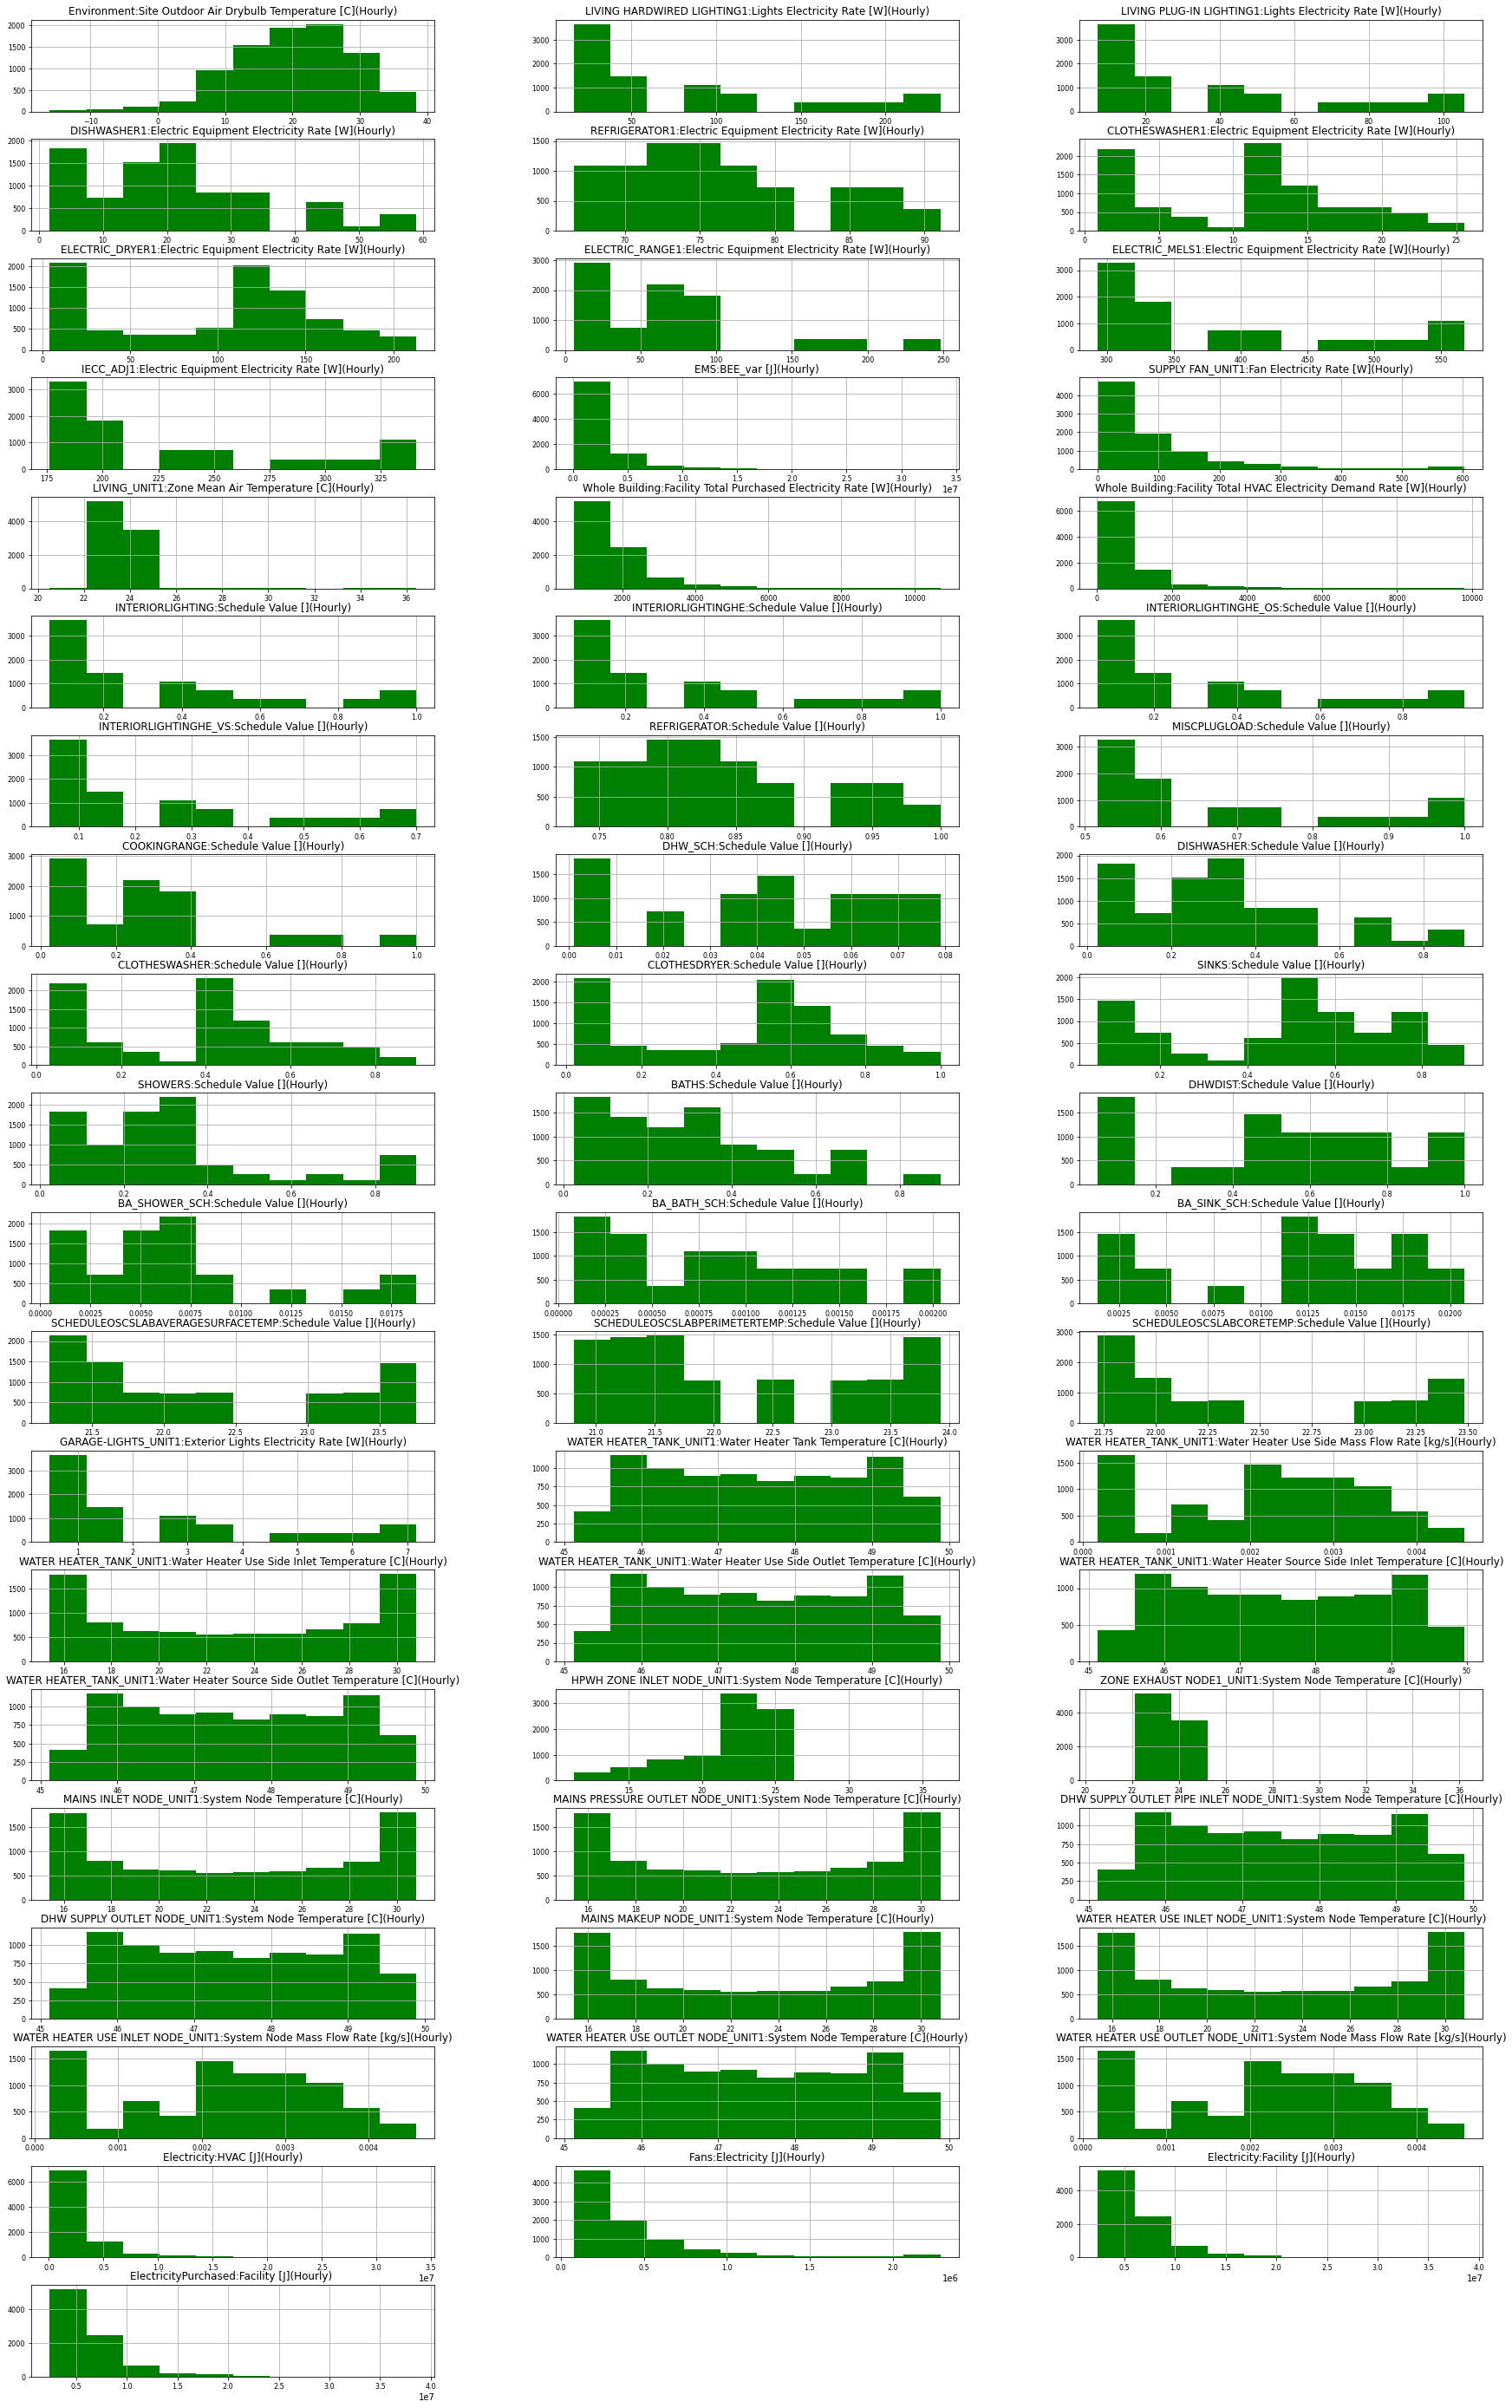

In [18]:
df_num.hist(bins=10, figsize=(30, 50), layout=(20, 3), color="green", xlabelsize=8, ylabelsize=8);

Observations:
- Columns which are following same type of distribution:
    - living hardwired lighting; living plugin lighting; interior lighting he_schedule value; interior lighting os_schedule value; interior lighting he_vs_schedule value; miscplugload schedule value; garage light units exterior - Follow uni-modal right-skewed distribution; No outliers
    - Dishwasher electric equipment & dishwasher schedule value - uni-modal and slightly right-skewed
    - Refigerator electric equipment & Refigerator schedule value - uni-modal and slightly right-skewed
    - Clotheswasher; electric dryer equipment - bi-modal and slightly left-skewed
    - Electricrange1; cooking range - bi-modal and slightly left-skewed
    - Electric MELS1; electric equipment rate - bi-modal and right-skewed
    - EMSBEE - most values in between 0-1 - uni-modal and so many outliers
    - Supply Fan unit; whole building electricity purchased facility; fans electricity; electricity facility; electricitypurchased facility - uni-modal and right-skewed and many outliers
    - Living unit zone1; zone exhaust model - uni-modal and slightly right-skewed and many outliers
    - whole building electricity demand facility; elecrtic hvac - uni-modal and right-skewed and mnay outliers
    - Interior lighting schedule valve - uni-modal and right skewed
    - DHW_SH_schedule valve - uni-modal and right skewed
    - clothesdryer - uni-modal and left skewed
    - sinks schedule valve - bi-modal and left skewed
    - shower schedule valve - uni-modal and slightly right skewed
    - baths schedule valve - uni-modal and slightly right skewed
    - dhwdist schedule valve - uni-modal and slightly left skewed
    - 

{'whiskers': [<matplotlib.lines.Line2D at 0x2b515f66c40>,
 'caps': [<matplotlib.lines.Line2D at 0x2b515f7c2e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b515f66970>],
 'medians': [<matplotlib.lines.Line2D at 0x2b515f7c7c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b515f7ca90>],
 'means': []}

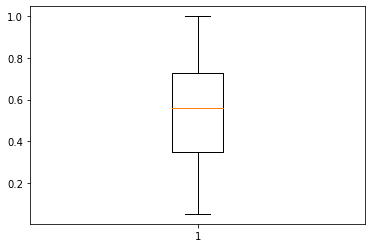

In [19]:
plt.boxplot(df['DHWDIST:Schedule Value [](Hourly)'])

In [20]:
df['DHWDIST:Schedule Value [](Hourly)'].describe()

count    8760.000000
mean        0.532150
std         0.286267
min         0.051661
25%         0.349602
50%         0.558790
75%         0.728829
max         1.000000
Name: DHWDIST:Schedule Value [](Hourly), dtype: float64

From the above observations from histplot, we can see there's a lot of multi-collinearity in the data.
So, let's remove variables with corr>0.95 before analyzing the data any further.

In [21]:
# Create correlation matrix
corr_matrix = df_num.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)
# Drop features 
df.drop(to_drop, axis=1, inplace=True)

['LIVING PLUG-IN LIGHTING1:Lights Electricity Rate [W](Hourly)', 'IECC_ADJ1:Electric Equipment Electricity Rate [W](Hourly)', 'Whole Building:Facility Total HVAC Electricity Demand Rate [W](Hourly)', 'INTERIORLIGHTING:Schedule Value [](Hourly)', 'INTERIORLIGHTINGHE:Schedule Value [](Hourly)', 'INTERIORLIGHTINGHE_OS:Schedule Value [](Hourly)', 'INTERIORLIGHTINGHE_VS:Schedule Value [](Hourly)', 'REFRIGERATOR:Schedule Value [](Hourly)', 'MISCPLUGLOAD:Schedule Value [](Hourly)', 'COOKINGRANGE:Schedule Value [](Hourly)', 'DISHWASHER:Schedule Value [](Hourly)', 'CLOTHESWASHER:Schedule Value [](Hourly)', 'CLOTHESDRYER:Schedule Value [](Hourly)', 'DHWDIST:Schedule Value [](Hourly)', 'BA_SHOWER_SCH:Schedule Value [](Hourly)', 'BA_BATH_SCH:Schedule Value [](Hourly)', 'BA_SINK_SCH:Schedule Value [](Hourly)', 'SCHEDULEOSCSLABPERIMETERTEMP:Schedule Value [](Hourly)', 'SCHEDULEOSCSLABCORETEMP:Schedule Value [](Hourly)', 'GARAGE-LIGHTS_UNIT1:Exterior Lights Electricity Rate [W](Hourly)', 'WATER HEATE

In [22]:
df.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Day Type Index [](Hourly),PEOPLE_UNIT1:People Occupant Count [](Hourly),LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly),DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly),REFRIGERATOR1:Electric Equipment Electricity Rate [W](Hourly),CLOTHESWASHER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_DRYER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_RANGE1:Electric Equipment Electricity Rate [W](Hourly),...,DHW_SCH:Schedule Value [](Hourly),SINKS:Schedule Value [](Hourly),SHOWERS:Schedule Value [](Hourly),BATHS:Schedule Value [](Hourly),SHADING_2009IECC:Schedule Value [](Hourly),SCHEDULEOSCSLABAVERAGESURFACETEMP:Schedule Value [](Hourly),EXTERIOR-LIGHTS_UNIT1:Exterior Lights Electricity Rate [W](Hourly),WATER HEATER_TANK_UNIT1:Water Heater Tank Temperature [C](Hourly),WATER HEATER_TANK_UNIT1:Water Heater Use Side Inlet Temperature [C](Hourly),HPWH ZONE INLET NODE_UNIT1:System Node Temperature [C](Hourly)
0,1900-01-01 01:00:00,4.758333,7,3.0,15.973112,8.155457,72.846060,2.774968,25.983483,11.702577,...,0.006,0.169852,0.081476,0.068986,0.85,21.514,43.242461,49.697860,16.135023,22.212488
1,1900-01-01 02:00:00,4.975000,7,3.0,15.973112,3.623467,71.270415,2.219380,15.590090,11.702577,...,0.003,0.081447,0.037000,0.034493,0.85,21.514,43.242461,49.193685,16.135023,22.222278
2,1900-01-01 03:00:00,5.391667,7,3.0,15.973112,2.714944,69.713093,1.108205,10.393393,5.843012,...,0.001,0.061055,0.025938,0.034493,0.85,21.514,43.242461,48.830153,16.135023,22.227402
3,1900-01-01 04:00:00,5.950000,7,3.0,15.973112,1.811734,67.642770,1.108205,5.196697,5.843012,...,0.001,0.061055,0.037000,0.034493,0.85,21.514,43.242461,48.504251,16.135023,22.236932
4,1900-01-01 05:00:00,6.258333,7,3.0,47.919336,1.811734,66.598447,2.219380,10.393393,11.702577,...,0.003,0.081447,0.103752,0.068986,0.85,21.514,43.242461,48.096483,16.135023,22.225905


In [24]:
# Categorical univariate analysis

In [25]:
# bi-variate analysis

In [26]:
# Pearson's correlation
df.corr(method='spearman')

,Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly),DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly),REFRIGERATOR1:Electric Equipment Electricity Rate [W](Hourly),CLOTHESWASHER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_DRYER1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_RANGE1:Electric Equipment Electricity Rate [W](Hourly),ELECTRIC_MELS1:Electric Equipment Electricity Rate [W](Hourly),EMS:BEE_var [J](Hourly),SUPPLY FAN_UNIT1:Fan Electricity Rate [W](Hourly),LIVING_UNIT1:Zone Mean Air Temperature [C](Hourly),Whole Building:Facility Total Purchased Electricity Rate [W](Hourly),DHW_SCH:Schedule Value [](Hourly),SINKS:Schedule Value [](Hourly),SHOWERS:Schedule Value [](Hourly),BATHS:Schedule Value [](Hourly),SCHEDULEOSCSLABAVERAGESURFACETEMP:Schedule Value [](Hourly),WATER HEATER_TANK_UNIT1:Water Heater Tank Temperature [C](Hourly),WATER HEATER_TANK_UNIT1:Water Heater Use Side Inlet Temperature [C](Hourly),HPWH ZONE INLET NODE_UNIT1:System Node Temperature [C](Hourly)
Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),1.000000,0.089625,0.010442,0.077654,-0.172524,-0.144815,-0.105676,0.198377,-0.048040,0.005264,0.826367,-0.086370,-0.058561,-0.052136,-0.097684,0.058578,0.757030,-0.039827,0.837895,0.588082
LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly),0.089625,1.000000,0.534491,0.588181,0.125291,0.113417,0.473376,0.762291,0.092938,0.107210,0.240897,0.518079,0.579057,0.579246,0.503102,0.737541,-0.000244,-0.024014,-0.000074,0.005780
DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly),0.010442,0.534491,1.000000,0.789216,0.717232,0.701066,0.687360,0.391553,0.087480,0.085510,0.137487,0.488369,0.711646,0.857866,0.552705,0.846490,-0.000574,0.024282,-0.000371,-0.095394
REFRIGERATOR1:Electric Equipment Electricity Rate [W](Hourly),0.077654,0.588181,0.789216,1.000000,0.428155,0.535993,0.708910,0.600923,0.106759,0.117034,0.239392,0.532815,0.427232,0.652545,0.130865,0.664299,-0.000097,0.017792,-0.000017,0.019183
CLOTHESWASHER1:Electric Equipment Electricity Rate [W](Hourly),-0.172524,0.125291,0.717232,0.428155,1.000000,0.927486,0.738586,-0.166126,-0.032730,-0.049803,-0.122457,0.177966,0.650105,0.753612,0.607370,0.522914,-0.001324,0.025611,-0.000968,-0.217613
ELECTRIC_DRYER1:Electric Equipment Electricity Rate [W](Hourly),-0.144815,0.113417,0.701066,0.535993,0.927486,1.000000,0.735070,-0.137867,-0.015459,-0.028494,-0.078127,0.208399,0.475165,0.628686,0.414237,0.439290,-0.001423,0.021810,-0.001061,-0.166644
ELECTRIC_RANGE1:Electric Equipment Electricity Rate [W](Hourly),-0.105676,0.473376,0.687360,0.708910,0.738586,0.735070,1.000000,0.175856,-0.003623,-0.002283,0.023500,0.343813,0.633094,0.814575,0.460716,0.514903,-0.000205,0.003560,-0.000067,-0.132066
ELECTRIC_MELS1:Electric Equipment Electricity Rate [W](Hourly),0.198377,0.762291,0.391553,0.600923,-0.166126,-0.137867,0.175856,1.000000,0.142429,0.160301,0.327595,0.513303,0.339861,0.343687,0.154238,0.609095,0.000024,0.005367,0.000033,0.099393
EMS:BEE_var [J](Hourly),-0.048040,0.092938,0.087480,0.106759,-0.032730,-0.015459,-0.003623,0.142429,1.000000,0.991751,0.080005,0.785295,0.022685,0.042431,-0.011265,0.105184,-0.003560,0.019759,-0.044689,0.010515
SUPPLY FAN_UNIT1:Fan Electricity Rate [W](Hourly),0.005264,0.107210,0.085510,0.117034,-0.049803,-0.028494,-0.002283,0.160301,0.991751,1.000000,0.144494,0.780572,0.017178,0.040495,-0.021426,0.106160,0.036574,0.001383,0.003258,0.072500


interval columns not set, guessing: ['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)', 'LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly)', 'DISHWASHER1:Electric Equipment Electricity Rate [W](Hourly)', 'REFRIGERATOR1:Electric Equipment Electricity Rate [W](Hourly)', 'CLOTHESWASHER1:Electric Equipment Electricity Rate [W](Hourly)', 'ELECTRIC_DRYER1:Electric Equipment Electricity Rate [W](Hourly)', 'ELECTRIC_RANGE1:Electric Equipment Electricity Rate [W](Hourly)', 'ELECTRIC_MELS1:Electric Equipment Electricity Rate [W](Hourly)', 'EMS:BEE_var [J](Hourly)', 'SUPPLY FAN_UNIT1:Fan Electricity Rate [W](Hourly)', 'LIVING_UNIT1:Zone Mean Air Temperature [C](Hourly)', 'Whole Building:Facility Total Purchased Electricity Rate [W](Hourly)', 'DHW_SCH:Schedule Value [](Hourly)', 'SINKS:Schedule Value [](Hourly)', 'SHOWERS:Schedule Value [](Hourly)', 'BATHS:Schedule Value [](Hourly)', 'SCHEDULEOSCSLABAVERAGESURFACETEMP:Schedule Value [](Hourly)', 'WATER HEATER_TANK_UNIT1:W

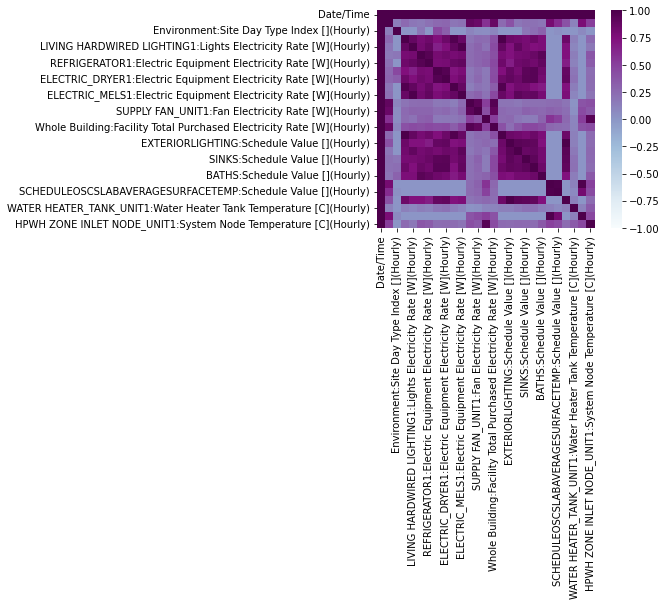

In [31]:
# Phik correlation
sns.heatmap(df.phik_matrix(), square=True, vmin=-1, vmax=1, cmap="BuPu");

In [32]:
# find highly correlated variables with target

In [33]:
# time series analysis - are there any seasonal and multiplicative? - what kind of 

In [34]:
# Hypothesis testing
 T_od - T_sp - P_hvac
    T-wh_tank-T_comp>5 - Pwater